In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
%cd gdrive/My\ Drive/PSOSM/Homework_3

/content/gdrive/My Drive/PSOSM/Homework_3


In [0]:
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
import numpy as np
import pandas as pd
import operator
import json
import warnings

# ignore warnings
warnings.filterwarnings(action='ignore')

In [0]:
# Read Data from Github
url = 'https://raw.githubusercontent.com/Ashwin-19/HW3/master/preprocessed.csv?token=AJD3RIUDW35WRHCB5ZAMRDS6PZDAU'
Dataset = pd.read_csv(url,error_bad_lines=False,lineterminator='\r')

In [11]:
# Select Features for the Model
dataset = Dataset[['followers','following','nlikes','nretweets','nreplies','verified','age','sentiment','plabel','ilabel']] 

# Remove NaN values
dataset.drop(dataset.tail(1).index,inplace=True) 
dataset = dataset.dropna()

dataset.head()

,followers,following,nlikes,nretweets,nreplies,verified,age,sentiment,plabel,ilabel
0,1517.0,1491.0,1.0,0.0,0.0,0.0,506.0,-0.05,report,fact
1,10.0,55.0,0.0,0.0,4.0,0.0,3414.0,0.25,other,chaos
2,81439.0,1967.0,15.0,2.0,2.0,1.0,2275.0,0.00,report,fact
3,104.0,98.0,0.0,0.0,0.0,0.0,3837.0,0.00,praise,fact
4,480.0,352.0,1.0,0.0,0.0,0.0,1268.0,0.00,action,fact


In [0]:
# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from copy import deepcopy

data = deepcopy(dataset)
le = preprocessing.LabelEncoder()

# Encode categorical columns
encoded = data[['plabel','ilabel']].apply(le.fit_transform)
data['plabel'] = encoded['plabel']
data['ilabel'] = encoded['ilabel']

In [0]:
# Splitting data into X and y
X = data.drop(labels='ilabel',axis=1)
y = data['ilabel']

In [0]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import svm

# initialize lowest possible score for model
max_score = 0

for i in range(50):
  # Splitting into train and test sets
  X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.25, random_state=5, stratify=y)

  # Oversampling due to imbalance in data
  X_train, y_train = SMOTE().fit_resample(X_train, y_train)

  # backup indices of test-set
  X_test_copy = deepcopy(X_test_temp)

  # Normalizing the Data
  scaler = preprocessing.StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test_temp = scaler.fit_transform(X_test_temp)

  # Training the model (SVM)
  clf = svm.SVC(kernel='rbf', gamma = 'auto', probability=True)
  clf.fit(X_train, y_train)

  # Evaluating the model (SVM)
  y_pred = clf.predict(X_test_temp)
  score = metrics.f1_score(y_test_temp, y_pred, average='micro')
  
  # select model with best accuracy
  if score > max_score:
    max_score = score
    model = clf
    X_test = X_test_temp
    y_test = y_test_temp
    test_X = X_test_copy

In [0]:
# saving the model
import pickle
filename = 'SVM.sav'
pickle.dump(model, open(filename, 'wb'))

# save test-set files
out_y = 'y_test.pkl'
outfile = open(out_y, 'wb')
np.save(outfile, y_test)

out_X = 'X_test.pkl'
outfile = open(out_X, 'wb')
np.save(outfile, X_test)

test_X.to_csv('test_X.csv')

In [14]:
from sklearn import metrics
from sklearn import svm
import pickle

filename = 'SVM.sav'
out_y = 'y_test.pkl'
out_X = 'X_test.pkl'

# load model and test data
clf = pickle.load(open(filename, 'rb'))
X_test = np.load(out_X,allow_pickle="True")
y_test = np.load(out_y,allow_pickle="True")
y_pred = clf.predict(X_test)

# evaluation metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.48      0.55       108
           1       0.62      0.49      0.55        71
           2       0.20      0.41      0.27        41

    accuracy                           0.47       220
   macro avg       0.49      0.46      0.46       220
weighted avg       0.56      0.47      0.50       220



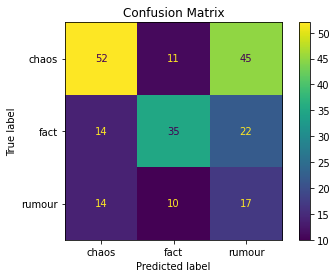

In [15]:
# plot confusion matrix
plot = metrics.plot_confusion_matrix(clf,X_test,y_test,display_labels=le.inverse_transform([0, 1, 2]))
plot.ax_.set_title("Confusion Matrix")
plt.show()

In [0]:
# load Test Data
Test_X = pd.read_csv('test_X.csv',index_col=0)

# calculating rumour likelihood for all tweets in test-set
rumour_likelihood = clf.predict_proba(X_test)[:,2]

# add column to test-set DataFrame
Test_X['rumour_likelihood'] = rumour_likelihood

In [0]:
# add text of tweets from main Dataset
tweets = Dataset[['tweet']] 

# merge with Test-Set
Test_X = Test_X.merge(tweets, how='inner', left_index=True, right_index=True)

# add test and predicted labels to test data
Test_X['ilabel'] = le.inverse_transform(y_test)
Test_X['predicted'] = le.inverse_transform(y_pred)

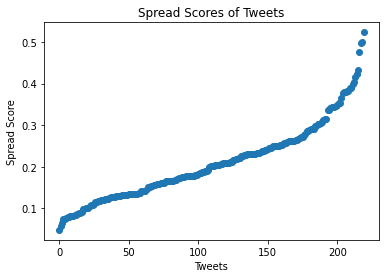

In [18]:
def spread_score(tweet):
  
  likes = tweet['nlikes']
  retweets = tweet['nretweets']
  replies = tweet['nreplies']
  verified = tweet['verified']
  followers = tweet['followers']

  s1 = 0.25*likes + 0.25*replies + 0.5*retweets 
  s1 = 1/(1+np.exp(-s1))

  s2 = (verified*0.4 + 0.2)*followers
  s2 = 1/(1+np.exp(-s2))

  rumour_likelihood = tweet['rumour_likelihood']

  return rumour_likelihood*s1*s2

scores = []
for index, row in Test_X.iterrows():
  scores.append(spread_score(row)) 

Test_X['spread_score'] = scores

scores.sort()

x = [i for i in range(len(scores))]

plt.title("Spread Scores of Tweets")
plt.xlabel("Tweets")
plt.ylabel("Spread Score")
plt.scatter(x,scores)
plt.show()

In [19]:
Test_X.head()

,followers,following,nlikes,nretweets,nreplies,verified,age,sentiment,plabel,rumour_likelihood,tweet,ilabel,predicted,spread_score
346,46.0,66.0,1.0,0.0,0.0,0.0,218.0,0.250000,3,0.314983,#DelhiRiot2020 \n\nKudos to bravery💪 \n\nWhat ...,fact,fact,0.177058
696,538.0,204.0,0.0,0.0,0.0,0.0,2179.0,0.000000,0,0.419376,Why act only when provoked\nGo and open jafrab...,chaos,rumour,0.209688
830,32946.0,439.0,4.0,0.0,0.0,0.0,3386.0,0.100000,0,0.342794,#Jafrabad Lathi Charge them. Clear the area @D...,chaos,chaos,0.250602
262,68.0,350.0,37.0,9.0,5.0,0.0,1033.0,0.033333,4,0.388192,@AmitShah @HMOIndia don't you think enough is ...,chaos,rumour,0.388191
845,126.0,174.0,0.0,0.0,1.0,0.0,1199.0,0.200000,2,0.391608,"@delhimetroapp shuts five stations,Monday even...",fact,rumour,0.220153


In [0]:
# divide into correctly predicted and incorrectly predicted tweets
correct = Test_X[Test_X['ilabel'] == Test_X['predicted']]
incorrect = Test_X[Test_X['ilabel'] != Test_X['predicted']]

# saving both csv's
correct.to_csv('correct_pred.csv')
incorrect.to_csv('incorrect_pred.csv')

In [31]:
# selecting 5 incorrectly classified tweets
# incorrect indices - 31, 143, 215, 342, 656
incorrect.loc[[31, 143, 215, 342, 656]].head()

,followers,following,nlikes,nretweets,nreplies,verified,age,sentiment,plabel,rumour_likelihood,tweet,ilabel,predicted,spread_score
31,408.0,546.0,1.0,1.0,0.0,0.0,2376.0,-0.125000,0,0.370103,This Parasite was the first to instigate peopl...,rumour,chaos,0.251366
143,279.0,65.0,7.0,8.0,1.0,0.0,3730.0,0.000000,2,0.253389,"@DelhiPolice, you were warned one day before a...",rumour,chaos,0.252762
215,229.0,1239.0,6.0,2.0,1.0,0.0,1509.0,0.285714,5,0.280065,Hatred towards a Muslims and weaponisation of ...,chaos,fact,0.263236
342,32.0,52.0,0.0,0.0,0.0,0.0,45.0,0.158929,5,0.236852,Victoria School was targeted right at 1 pm by ...,rumour,fact,0.118230
656,1837.0,57.0,24.0,22.0,0.0,0.0,3719.0,-0.106250,2,0.229974,What do you mean by ‘whoever’\n\nIsn’t it ampl...,rumour,chaos,0.229974


In [27]:
# selecting 5 correctly classified tweets
# correct indices - 32, 59, 653, 69, 19
correct.loc[[32, 59, 653, 69, 19]].head()

,followers,following,nlikes,nretweets,nreplies,verified,age,sentiment,plabel,rumour_likelihood,tweet,ilabel,predicted,spread_score
32,18.0,1008.0,0.0,0.0,1.0,0.0,27.0,-0.241667,5,0.497421,Afterwards come after 3 days not same day and ...,rumour,rumour,0.272201
59,39.0,79.0,0.0,0.0,0.0,0.0,210.0,0.087500,2,0.463543,Since ISIS level terrorism was created by bunc...,rumour,rumour,0.231676
653,229.0,1239.0,0.0,0.0,0.0,0.0,1509.0,-0.100000,4,0.420984,I am saying it again and again that this riot ...,rumour,rumour,0.210492
69,18.0,1008.0,0.0,0.0,1.0,0.0,27.0,0.000000,2,0.574512,And why suddenly these riots just started when...,rumour,rumour,0.314387
19,102.0,905.0,2.0,1.0,0.0,0.0,159.0,0.250000,0,0.391491,Mr PRIME MINISTER @narendramodi \n\nNE Delhi i...,rumour,rumour,0.286203
